<a href="https://colab.research.google.com/github/Jackson00Han/Time-Series-Training/blob/main/multivariate_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

Thie project aims to predict the future one week Global_active_power values.

##  1. Data Preprocessing


## 1-1. Set Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
df = pd.read_csv('household_power_consumption.txt', delimiter=';', low_memory=False)
df.head()

Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0

In [3]:
df.shape

(2075259, 9)

## 1-2. Managing Time Column

In [4]:
# Manage time column

# I usually set the datetime as the index. You may keep the origional index and datetime column,
# then you just need to use datetime column instead of index later, when selecting data.
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.drop(['Date', 'Time'], axis=1, inplace=True)
df.set_index('datetime', inplace=True)

# Ensure time series is sorted
df.sort_index(inplace=True)

# Calculate time differences
time_diffs = df.index.to_series().diff()

# Identify any irregularities, apart from the first row
irregularities = time_diffs[time_diffs != time_diffs.mode()[0]][1:]

# Display irregularities, if any
if irregularities.empty:
    print("No irregularities found.")
else:
    print("Irregularities found at:")
    print(irregularities)

No irregularities found.


## 1-3. Handling Missing Values

In [5]:
# Replacing Specific Non-Numeric Values with NaN

# List of non-numeric values to replace
non_numeric_values = ['?', 'N/A', '-', '']

for col in df.columns:
    df[col] = df[col].replace(non_numeric_values, np.nan)
    df[col] = df[col].astype('float64')

In [6]:
# Check out null value situation
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


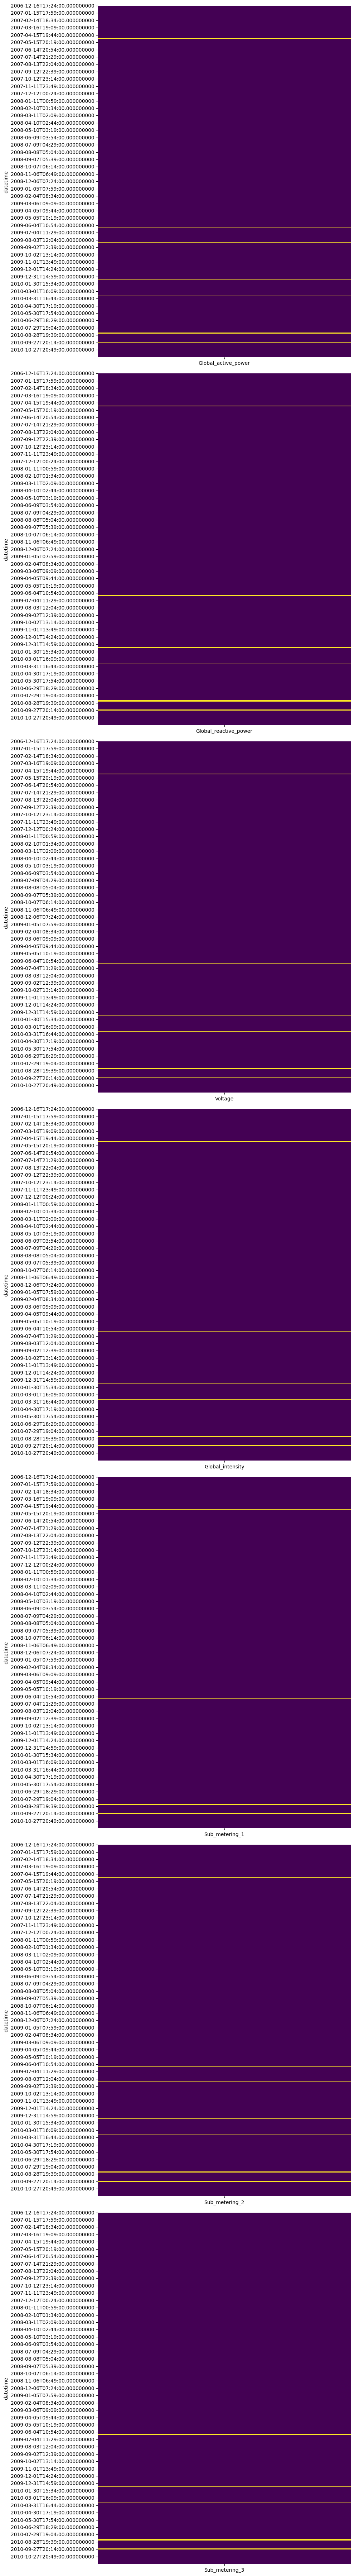

In [8]:
fig, axs = plt.subplots(7, 1, figsize=(10, 72))

for i, col in enumerate(df.columns[:]):
    sns.heatmap(df[col].isna().to_frame(), cbar=False,cmap='viridis', ax=axs[i])
plt.tight_layout()
plt.show()

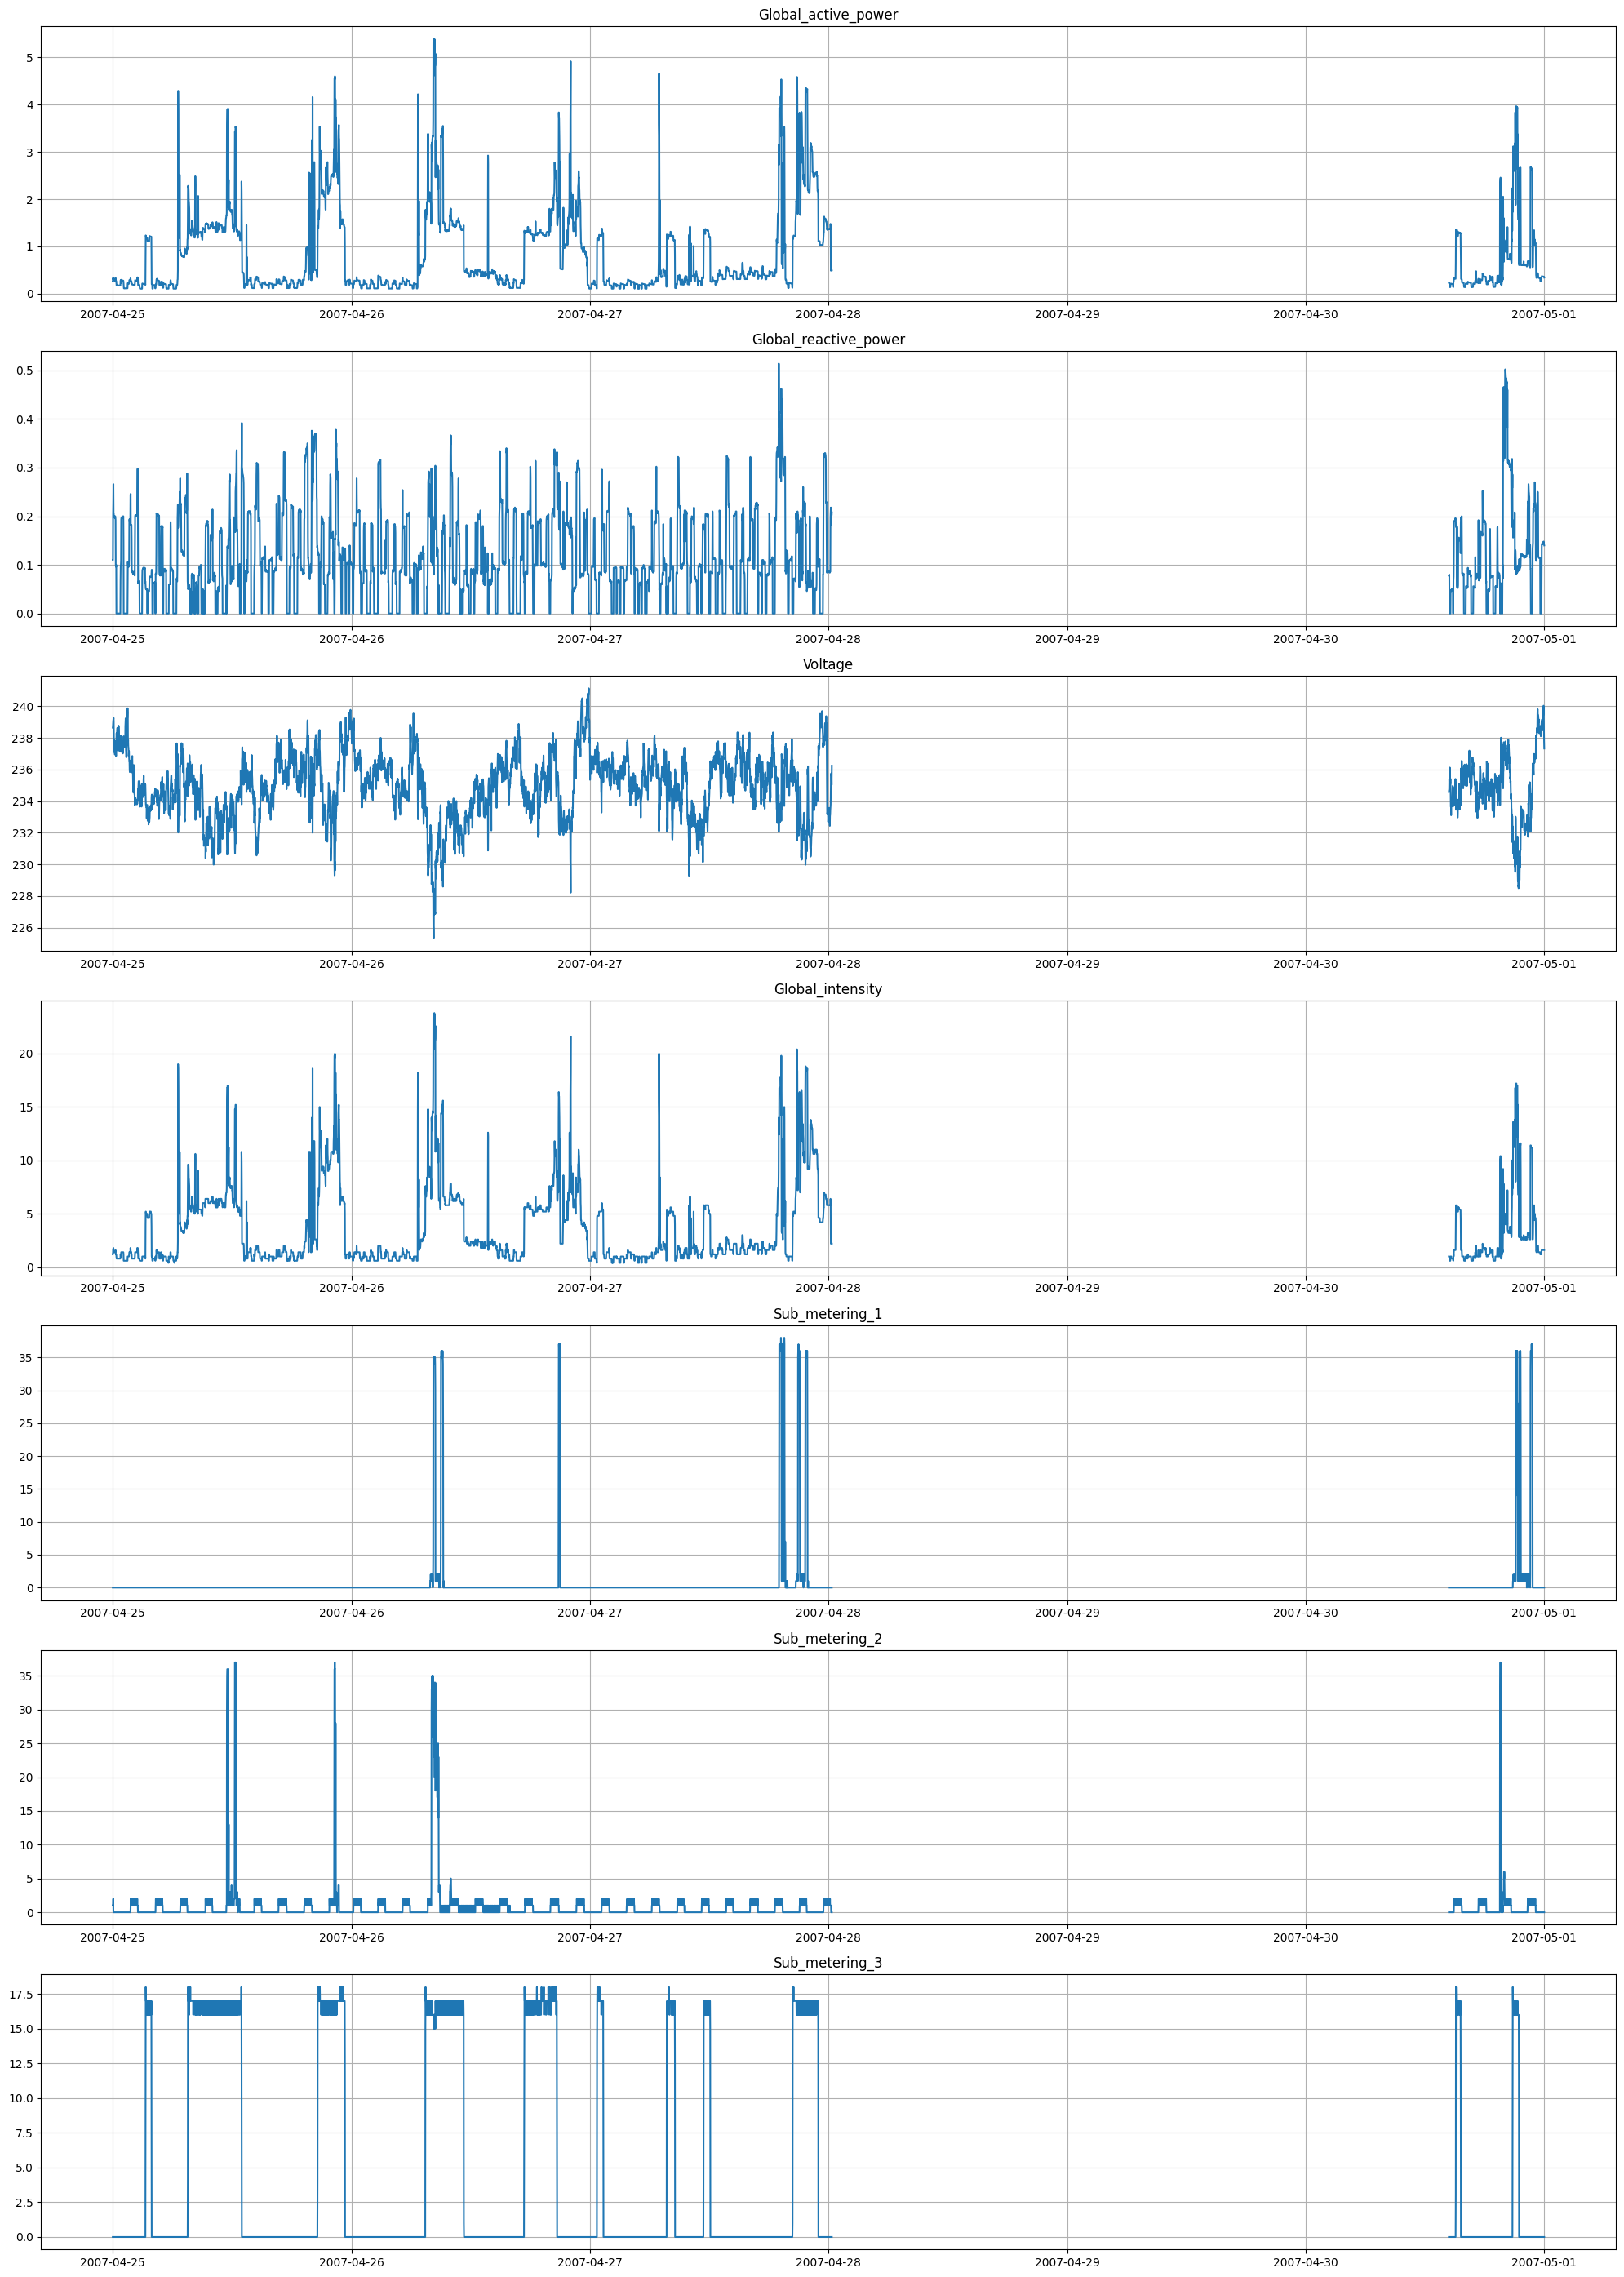

In [9]:
# Visualizting one period of missing values of different columns

fig, axs = plt.subplots(7, 1, figsize=(20,28))
for i, col in enumerate(df.columns[:]):
    axs[i].plot(df[col].loc['2007-04-25 00:00:00':'2007-05-01 00:00:00'])
    axs[i].set_title(col)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [10]:
# The best way to imputing the missing value could be using time seroes models to predict these value, but I will apply a simpler method --
# impute the missing values with rolling means:
window_wize = 60*24*7

for col in df.columns:
    df[col] = df[col].fillna(df[col].rolling(window=window_wize, min_periods=1).mean())

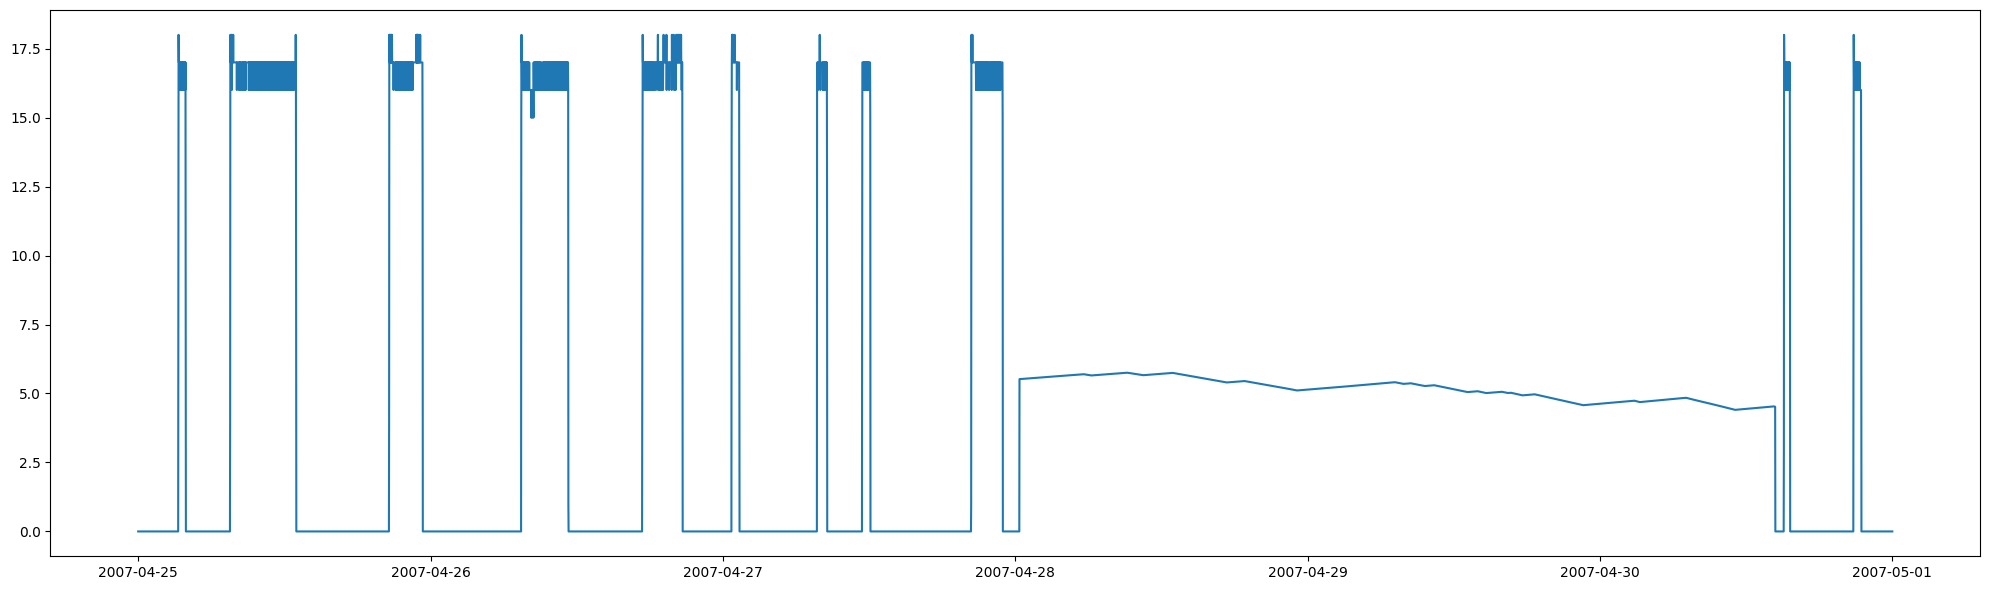

In [11]:
# Check oen columns again

fig, ax = plt.subplots(figsize=(20,6))

ax.plot(df['Sub_metering_3'].loc['2007-04-25 00:00:00':'2007-05-01 00:00:00'])
plt.tight_layout()
plt.show()

In [12]:
df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

## 1-4. Formating Data Types

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


## 2. EDA

## 2-1. Visualizing Data

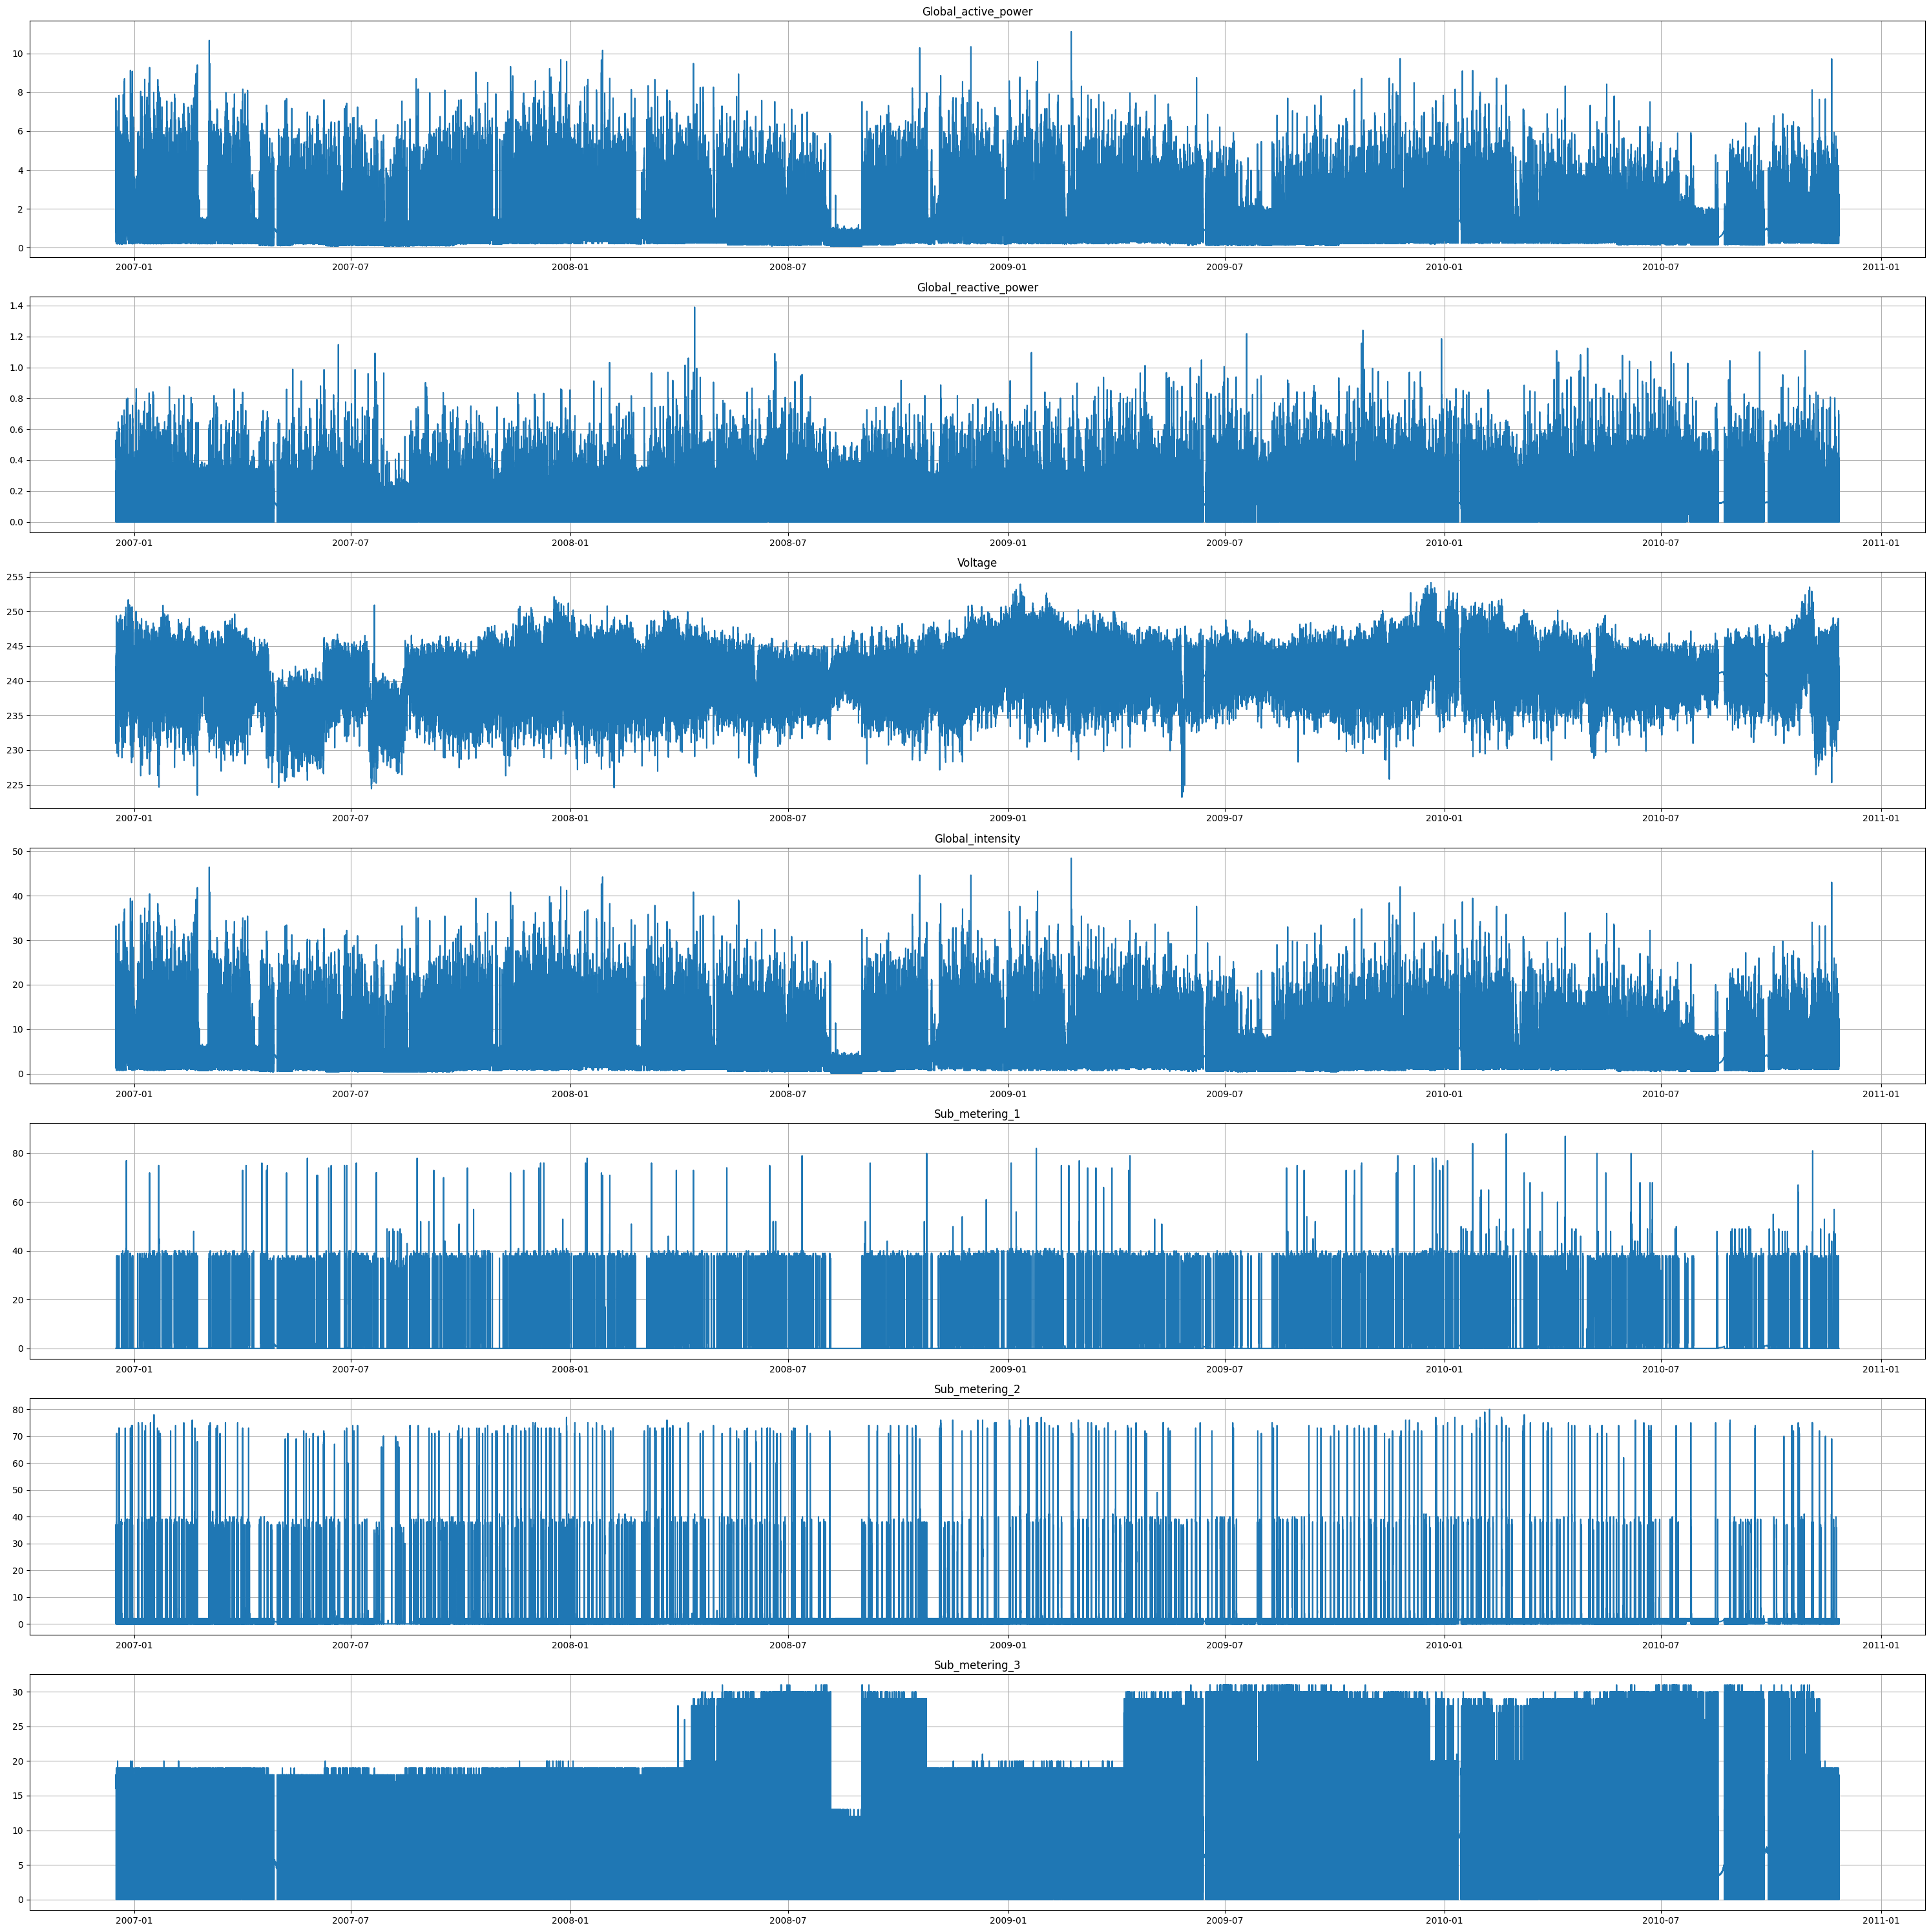

In [14]:
fig, axs = plt.subplots(7, 1, figsize=(30, 30))

for i, col in enumerate(df.columns[:]):
    axs[i].plot(df[col])
    axs[i].set_title(col)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

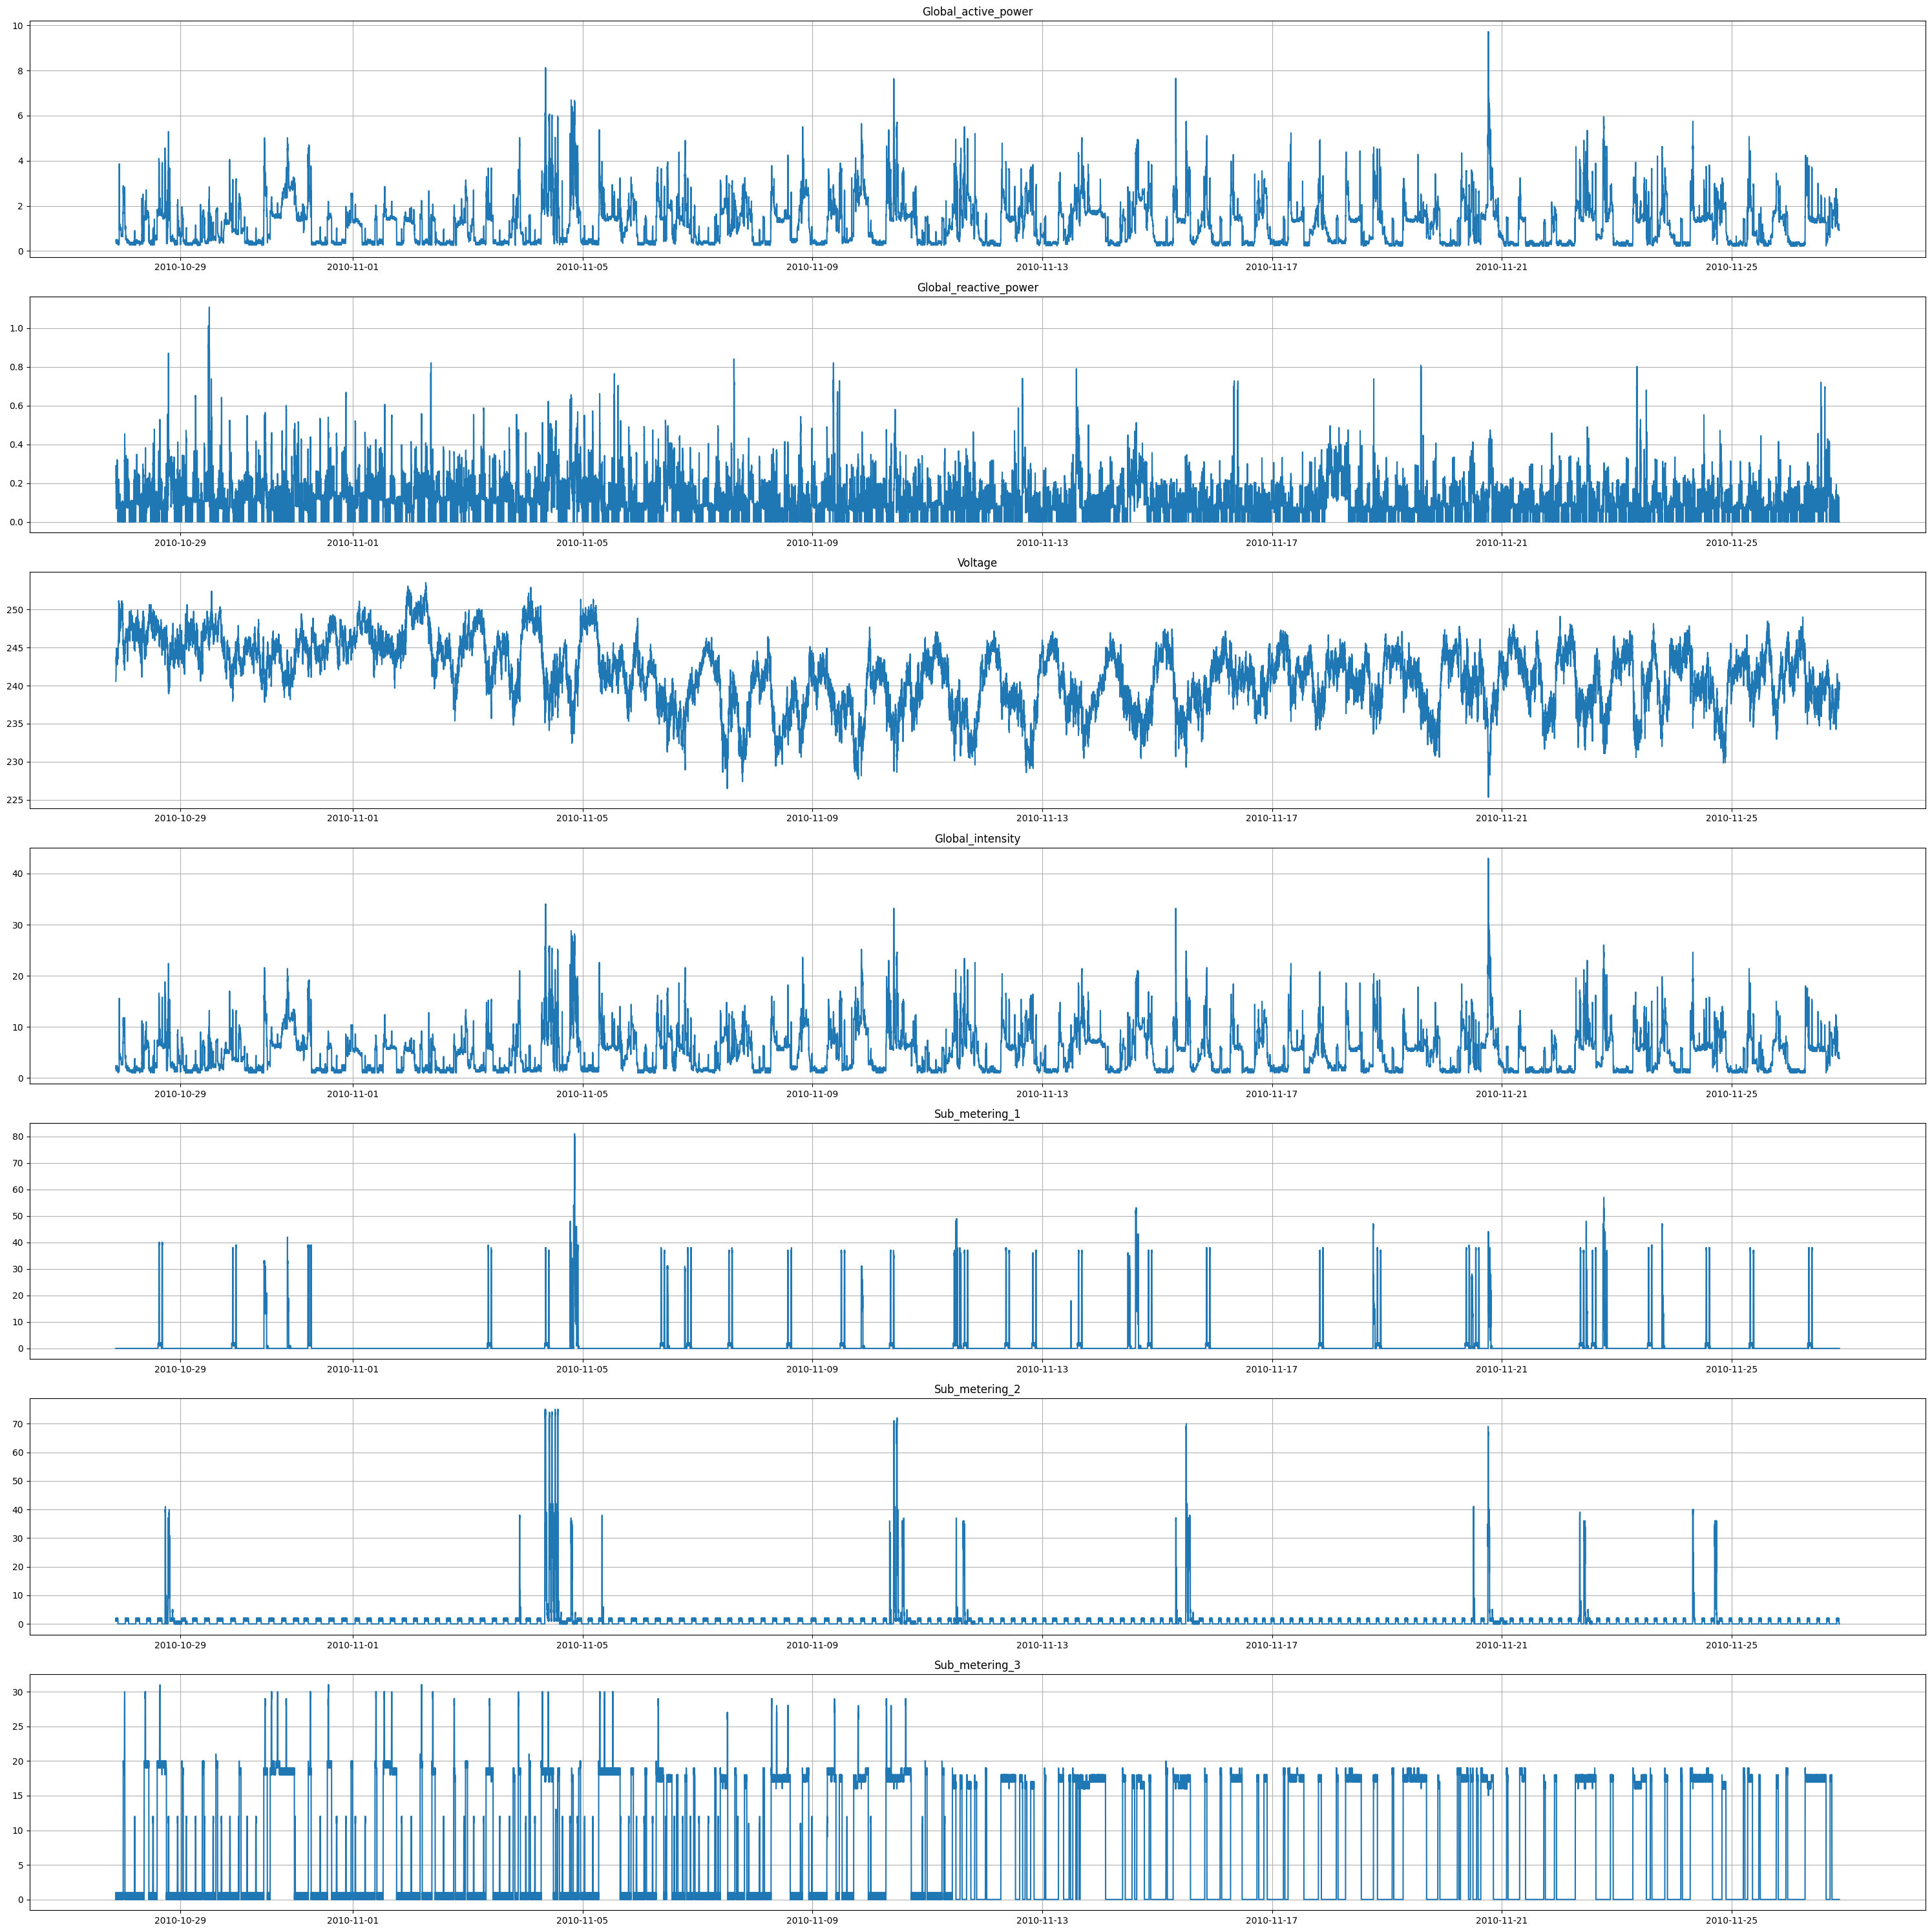

In [15]:
# Visualize a few data at the end

fig, axs = plt.subplots(7, 1, figsize=(30, 30))

for i, col in enumerate(df.columns[:]):
    axs[i].plot(df[col][-60*24*30:])
    axs[i].set_title(col)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

## 2-2 Statistics of the Dataset

In [16]:
df.describe().transpose()

count        mean       std      min      25%  \
Global_active_power    2075259.0    1.089427  1.051226    0.076    0.310   
Global_reactive_power  2075259.0    0.123711  0.112024    0.000    0.048   
Voltage                2075259.0  240.838740  3.230229  223.200  239.000   
Global_intensity       2075259.0    4.618755  4.418696    0.200    1.400   
Sub_metering_1         2075259.0    1.118185  6.114620    0.000    0.000   
Sub_metering_2         2075259.0    1.294622  5.785694    0.000    0.000   
Sub_metering_3         2075259.0    6.453180  8.386904    0.000    0.000   

                           50%      75%      max  
Global_active_power      0.620    1.520   11.122  
Global_reactive_power    0.102    0.192    1.390  
Voltage                241.010  242.870  254.150  
Global_intensity         2.800    6.400   48.400  
Sub_metering_1           0.000    0.000   88.000  
Sub_metering_2           0.000    1.000   80.000  
Sub_metering_3           1.000   17.000   31.000

In [17]:
df.corr()

Global_active_power  Global_reactive_power   Voltage  \
Global_active_power               1.000000               0.246804 -0.397335   
Global_reactive_power             0.246804               1.000000 -0.111623   
Voltage                          -0.397335              -0.111623  1.000000   
Global_intensity                  0.998888               0.265908 -0.409038   
Sub_metering_1                    0.484354               0.123088 -0.195361   
Sub_metering_2                    0.434513               0.139227 -0.166545   
Sub_metering_3                    0.638750               0.089532 -0.266264   

                       Global_intensity  Sub_metering_1  Sub_metering_2  \
Global_active_power            0.998888        0.484354        0.434513   
Global_reactive_power          0.265908        0.123088        0.139227   
Voltage                       -0.409038       -0.195361       -0.166545   
Global_intensity               1.000000        0.489264        0.440298   
Sub_metering_1                 0.489264        1.000000        0.054753   
Sub_metering_2                 0.440298        0.054753        1.000000   
Sub_metering_3                 0.626737        0.102675        0.080930   

                       Sub_metering_3  
Global_active_power          0.638750  
Global_reactive_power        0.089532  
Voltage                     -0.266264  
Global_intensity             0.626737  
Sub_metering_1               0.102675  
Sub_metering_2               0.080930  
Sub_metering_3               1.000000

## 2-3 Data Preparation

### 2-3-1 Train Test Split

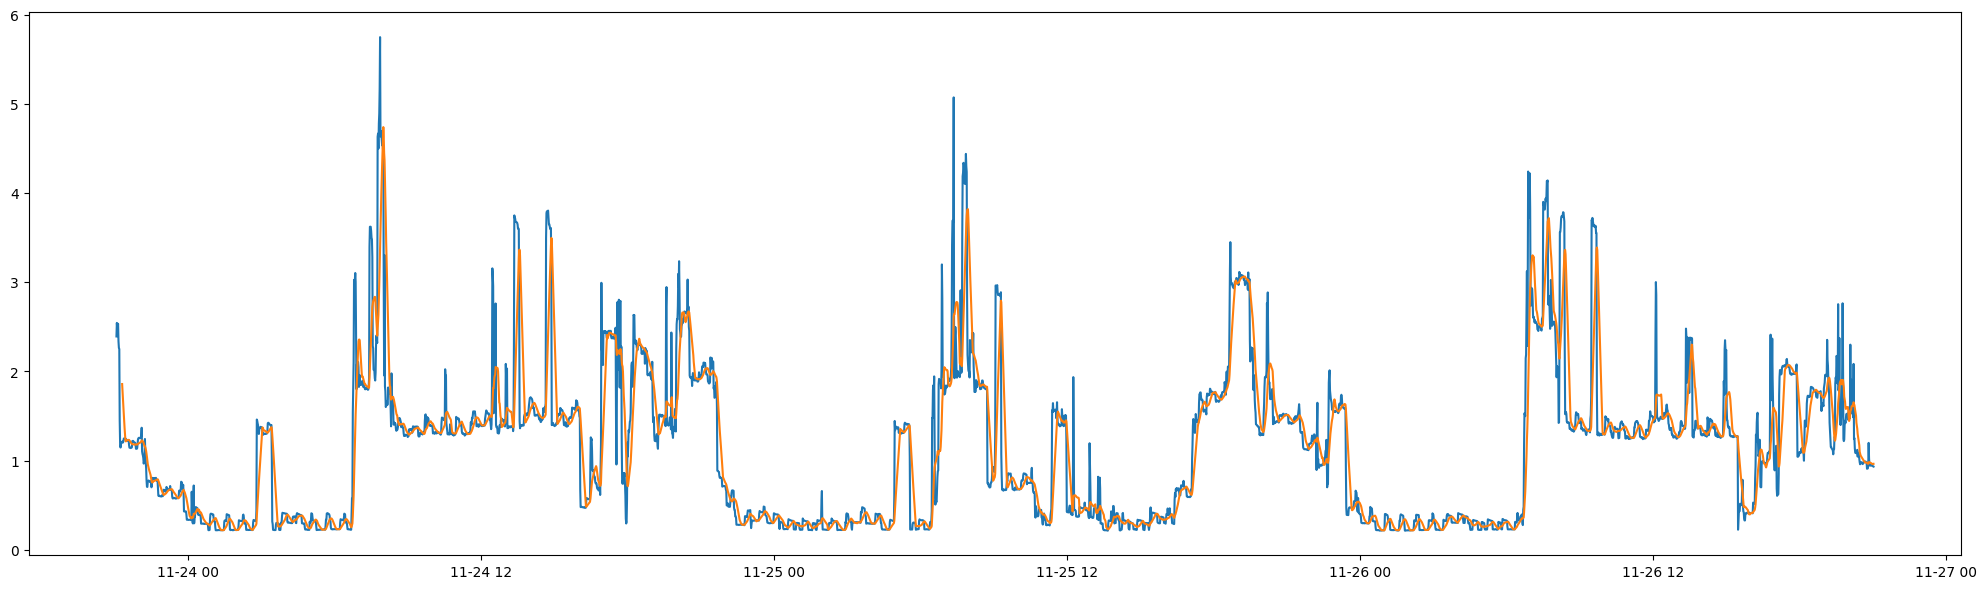

In [33]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(df['Global_active_power'][-60*24*3:])
ax.plot(df['Global_active_power'][-60*24*3:].rolling(window=15).mean())
plt.tight_layout()
plt.show()

In [39]:
split_time = -60*24*14
train = df.iloc[-60*24*28:split_time]
test = df.iloc[split_time:]

In [40]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series, not necessarily univariate
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [41]:
train.shape

(20160, 7)

In [45]:
# Parameters
window_size = 60
batch_size = 32
shuffle_buffer_size = 60*24*14 # this value depends on the size of the data, around the len(data) for small data and smaller len(data) for big data



In [46]:
# Generate the dataset windows
train_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer_size)

In [47]:
for windows in train_set.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 60, 7)
shape of second element: (32, 7)


In [48]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten


# Build the RNN Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='causal', activation='relu',
                          input_shape=[None,7]),
    tf.keras.layers.LSTM(8, return_sequences=False),
    tf.keras.layers.Dense(7),
])
# Compile the model
model.compile(loss="mse", optimizer="adam")

# Train the model
model.fit(train_set, epochs=10)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 8166.8779
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


629/629 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 7780.7192
Epoch 3/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 7487.7627
Epoch 4/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 7206.2915
Epoch 5/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 6931.4087
Epoch 6/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 6665.3853
Epoch 7/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 6400.3740
Epoch 8/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 6146.9512
Epoch 9/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 5898.8267
Epoch 10/10
629/629 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 5653.5312


In [49]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

In [50]:
sample_test = test[:1000]

In [51]:
forecast = model_forecast(model, sample_test, window_size, batch_size)

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [52]:
forecast.shape

(941, 7)

In [53]:
forecast1 = forecast[:,0].tolist()

In [54]:
actual = test[60:1001]
actual.shape

(941, 7)

In [55]:
actual = actual.iloc[:,0].tolist()

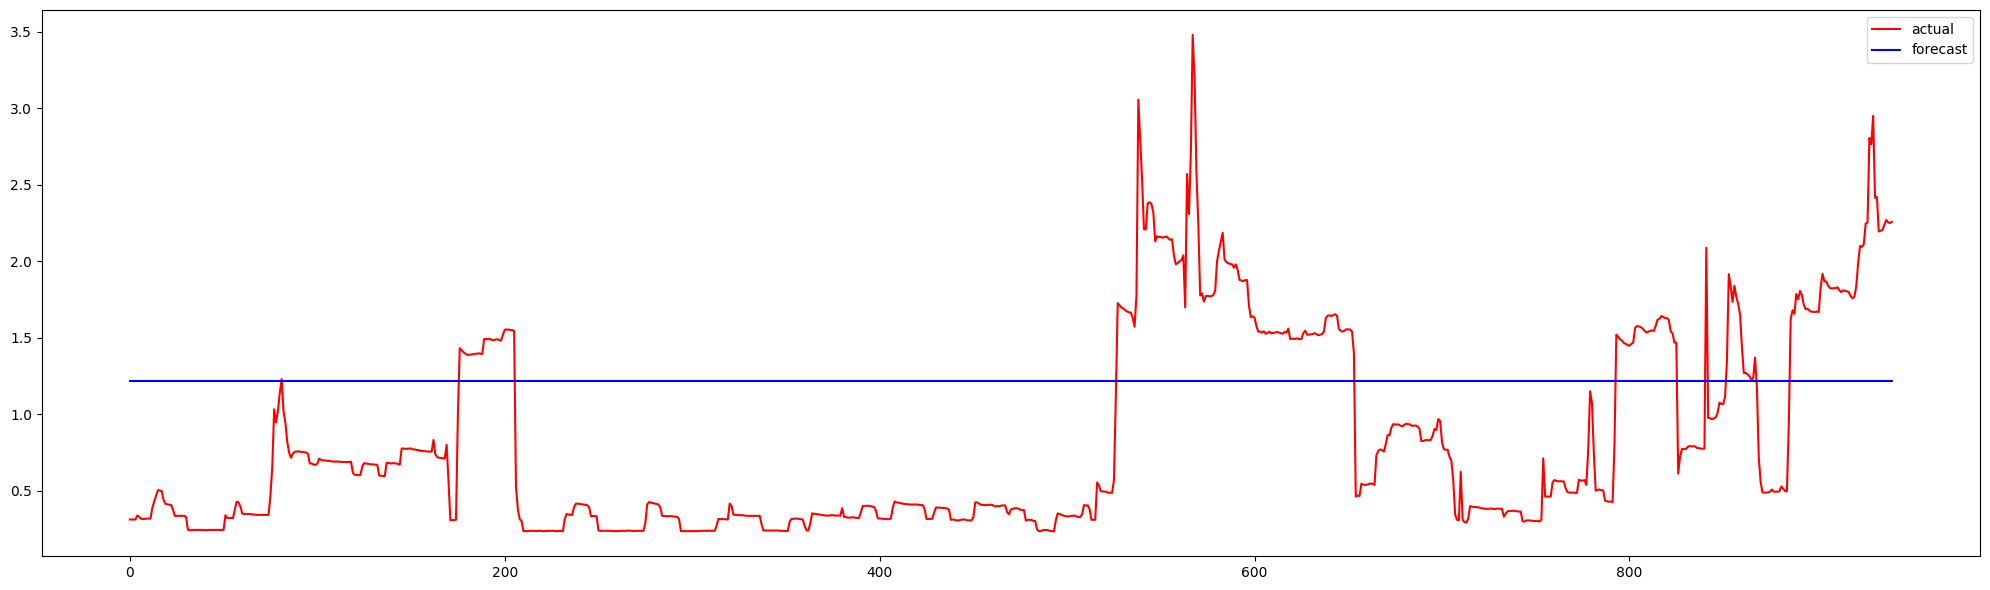

In [56]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual, c='red', label='actual')
ax.plot(forecast1, c= 'blue', label='forecast')
plt.legend()
plt.tight_layout()
plt.show()